In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [3]:
df = pd.read_csv('weatherAUS.csv')
df

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145407,145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145408,145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145409,145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145410,145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [4]:
def city_dataframe(city):
    df_city = df[df['Location'] == city]
    return df_city

def plot_temperature(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    sns.lineplot(x="Date", y="MaxTemp", data=df, color='red')
    sns.lineplot(x="Date", y="MinTemp", data=df, color='blue')
    plt.xticks(rotation=90)
    plt.xticks(np.arange(0, len(df), 30))
    plt.show()

In [5]:
uluru_df = city_dataframe('Uluru')
uluru_df

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
143835,143882,2013-03-01,Uluru,19.7,30.0,0.8,NaN,NaN,ESE,48.0,...,54.0,1010.6,1007.5,NaN,NaN,21.7,28.4,No,No,0.0
143836,143883,2013-03-02,Uluru,21.6,33.1,0.0,NaN,NaN,E,33.0,...,33.0,1010.5,1006.5,NaN,NaN,24.6,31.3,No,No,0.0
143837,143884,2013-03-03,Uluru,21.3,36.1,0.0,NaN,NaN,E,33.0,...,27.0,1006.9,1002.7,NaN,NaN,27.6,34.5,No,No,0.0
143838,143885,2013-03-04,Uluru,22.9,37.7,0.0,NaN,NaN,ENE,39.0,...,22.0,1006.0,1002.1,NaN,NaN,28.7,35.4,No,No,0.0
143839,143886,2013-03-05,Uluru,24.0,39.0,0.0,NaN,NaN,S,39.0,...,21.0,1006.9,1003.5,NaN,NaN,29.9,37.3,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145407,145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145408,145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145409,145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145410,145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [13]:
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [19]:
#Show all diferent cities
cities=df['Location'].unique()
print(cities)

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


In [ ]:
#Read the shapefile
map_df = gpd.read_file('SA2_2016_AUST.shp')

#Create a new column with the coordinates of each city
cities_coord = {'Adelaide': (-34.9285, 138.6007),
                'Albany': (-35.0031, 117.8657),
                'Albury': (-36.0737, 146.9135),
                'AliceSprings': (-23.6980, 133.8807),
                'BadgerysCreek': (-33.8813, 150.7400),
                'Ballarat': (-37.5622, 143.8503),
                'Bendigo': (-36.7570, 144.2794),
                'Brisbane': (-27.4698, 153.0251),
                'Cairns': (-16.9186, 145.7781),
                'Canberra': (-35.2809, 149.1300),
                'Cobar': (-31.4983, 145.8344),
                'CoffsHarbour': (-30.2963, 153.1131),
                'Dartmoor': (-37.9223, 141.2760),
                'Darwin': (-12.4634, 130.8456),
                'GoldCoast': (-28.0167, 153.4000),
                'Hobart': (-42.8821, 147.3272),
                'Katherine': (-14.4644, 132.2630),
                'Launceston': (-41.4545, 147.1317),
                'Melbourne': (-37.8136, 144.9631),
                'MelbourneAirport': (-37.6690, 144.8410),
                'Mildura': (-34.2083, 142.1270),
                'Moree': (-29.4638, 149.8413),
                'MountGambier': (-37.8241, 140.7798),
                'MountGinini': (-35.5294, 148.7720),
                'Newcastle': (-32.9283, 151.7817),
                'Nhil': (-36.3328, 141.6503),
                'NorahHead': (-33.2833, 151.5667),
                'NorfolkIsland': (-29.0408, 167.9547),
                'Nuriootpa': (-34.4667, 138.9833),
                'PearceRAAF': (-31.6675, 116.0158),
                'Penrith': (-33.7581, 150.6950),
                'Perth': (-31.9522, 115.8589),
                'PerthAirport': (-31.9405, 115.9660),
                'Portland': (-38.3511, 141.6056),
                'Richmond': (-33.6000, 150.7500),
                'Sale': (-38.1063, 147.0674),
                'SalmonGums': (-32.9819, 121.6431),
                'Sydney': (-33.8688, 151.2093),
                'SydneyAirport': (-33.9461, 151.1772),
                'Townsville': (-19.2583, 146.8169),
                'Tuggeranong': (-35.4244, 149.0887),
                'Uluru': (-25.3444, 131.0369),
                'WaggaWagga': (-35.1082, 147.3598),
                'Walpole': (-34.9772, 116.7317),
                'Watsonia': (-37.7114, 145.0831),
                'Williamtown': (-32.8150, 151.8428),
                'Witchcliffe': (-34.0264, 115.1000),
                'Wollongong': (-34.4241, 150.8931),
                'Woomera': (-31.1997, 136.8256)}

#Create a new column with the coordinates of each city
df['Coordinates'] = df['Location'].map(cities_coord)

#Create two new columns with the latitude and longitude of each city
df[['Latitude', 'Longitude']] = df['Coordinates'].apply(pd.Series)

#Create a new column with the geometry of each city
df['Coordinates'] = list(zip(df.Longitude, df.Latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)
df

#Create a new dataframe with the geometry of each city
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')
gdf

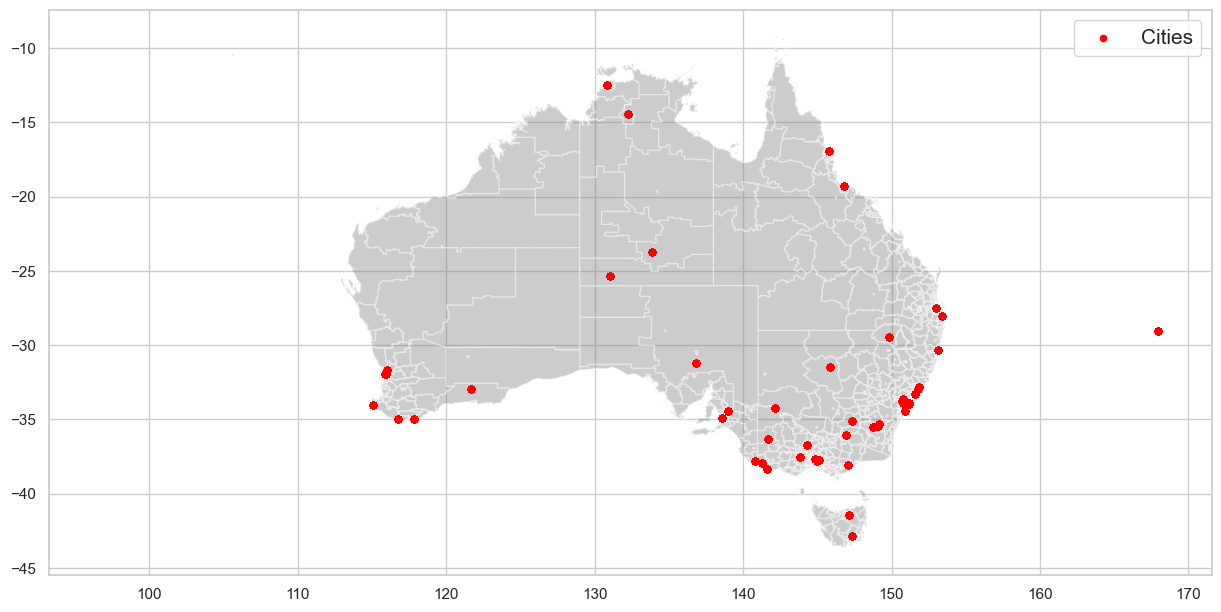

In [36]:
#Check the map
fig, ax = plt.subplots(figsize=(15,15))
map_df.plot(ax=ax, alpha=0.4, color='grey')
gdf.plot(ax=ax, markersize=20, color='red', marker='o', label='Cities')
plt.legend(prop={'size': 15})
plt.show()

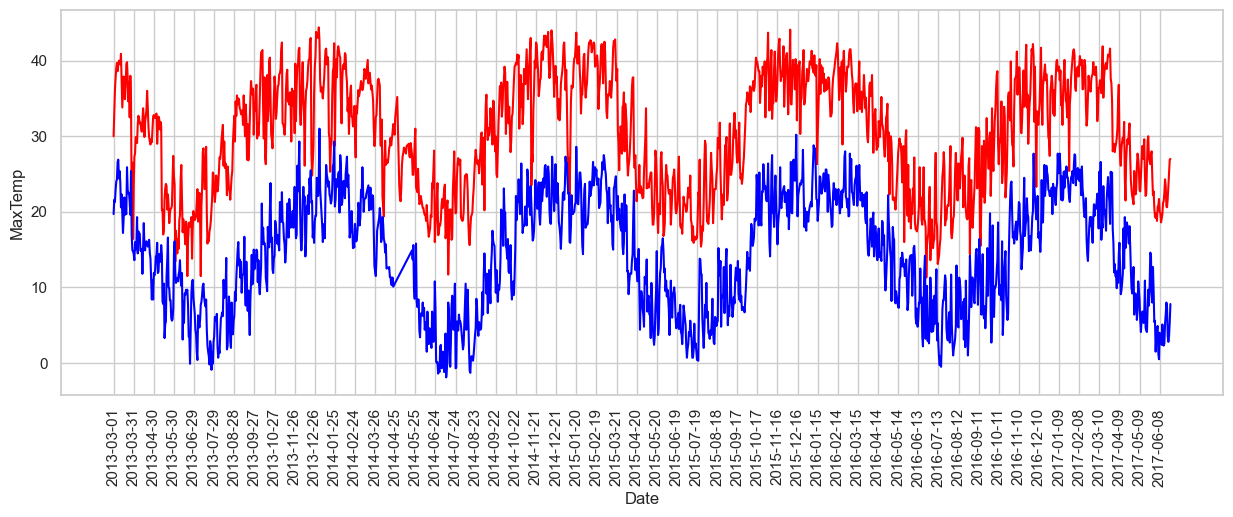

In [12]:
plot_temperature(uluru_df)